# E-06. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

##  1.모듈 및 데이터 불러오기


In [4]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import xgboost as xgb
import lightgbm as lgb

import os
from os.path import join

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

RANDOM_SEED = 2021
np.random.seed(RANDOM_SEED)

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
# from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer #Analysis 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.cluster import KMeans
from scipy.special import boxcox1p
from sklearn.model_selection import GridSearchCV

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'



In [10]:
def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
    
def load_data():
    
        train_data_path = join(data_dir, 'train.csv')
        test_data_path = join(data_dir, 'test.csv')
        train = pd.read_csv(train_data_path)
        test = pd.read_csv(test_data_path)
        
        train_copy = train.copy()
        test_copy = test.copy()
        train_copy['data'] = 'train'
        test_copy['data'] = 'test'
        test_copy['price'] = np.nan

        train_copy = train_copy[~((train_copy['sqft_living'] > 12000) & (train_copy['price']< 3000000))].reset_index(drop=True) # 이상치 제거
        train_copy['date'] = train_copy['date'].apply(lambda i: i[:6]).astype(int) # 년,월로 전처리
        # data.drop('date', axis=1, inplace=True)    

        data = pd.concat([train_copy,test_copy], sort=False).reset_index(drop=True)  
        data = data[train_copy.columns]  
        
        data['zipcode'] = data['zipcode'].astype(str)
        target_col = ['price']

        for i in target_col:
            data[i] = np.log1p(data[i])
        
        return data

def train_test_split(data, ideal=True):
        df = data.drop(['id','price','data'], axis=1).copy() # 데이터 값을 복사하여 저장
        cat_cols = df.select_dtypes('object').columns  # dtype이 object인 컬럼 date,zipcode 선택
        for col in cat_cols: 
            if ideal:
                ohe_df = pd.get_dummies(df[[col]], prefix='ohe_'+col) #zipcode 및 date에 가변수 만들기
                df.drop(col, axis=1, inplace=True) # 기존 컬럼이던 zipcode, date 제거
                df = pd.concat([df, ohe_df], axis=1) # 데이터와 가변수 컬럼 합치기
            else:
                le = LabelEncoder() # 문자를 수치화(숫자를 문자로 매핑)
                df[col] = le.fit_transform(df[col]) # 
                
        train_len = data[data['data'] == 'train'].shape[0]
        X_train = df.iloc[:train_len]
        X_test = df.iloc[train_len:]
        y_train = data[data['data'] == 'train']['price']

        return X_train,X_test,y_train

def get_oof_lgb(X_train, y_train, X_test, lgb_param, verbose_eval=False, return_cv_score_only=False):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 교차검증
    oof = np.zeros(len(X_train))  #
    predictions = np.zeros(len(X_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
        cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        
        if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    if return_cv_score_only: return cv_score
    else: return oof, predictions, cv_score, feature_importance_df



def plot_categorical_for_regression(df, field, target_field='price', show_missing=True, missing_value='NA'):
    df_copy = df.copy()
    if show_missing: df_copy[field] = df_copy[field].fillna(missing_value)
    df_copy = df_copy[df_copy[field].notnull()]

    ax1_param = 121
    ax2_param = 122
    fig_size = (16, 7)
    if df_copy[field].nunique() > 30:
        ax1_param = 211
        ax2_param = 212
        fig_size = (16, 10)
    
    fig = plt.figure(figsize = fig_size)
    ax1 = plt.subplot(ax1_param)
    
    sns.countplot(x=field, hue='data', order=np.sort(df_copy[field].unique()), data=df_copy)
    plt.xticks(rotation=90, fontsize=11)
    
    ax2 = plt.subplot(ax2_param)
    
    df_copy = df_copy[df_copy['data'] == 'train']

    sns.boxplot(x=field, y=target_field, data=df_copy, order=np.sort(df_copy[field].unique()), ax=ax2)
    plt.xticks(rotation=90, fontsize=11)
    
    plt.show()

def plot_numeric_for_regression(df, field, target_field='price'):
    df = df[df[field].notnull()]

    fig = plt.figure(figsize = (16, 7))
    ax1 = plt.subplot(121)
    
    sns.distplot(df[df['data'] == 'train'][field], label='Train', hist_kws={'alpha': 0.5}, ax=ax1)
    sns.distplot(df[df['data'] == 'test'][field], label='Test', hist_kws={'alpha': 0.5}, ax=ax1)

    plt.xlabel(field)
    plt.ylabel('Density')
    plt.legend()
    
    ax2 = plt.subplot(122)
    
    df_copy = df[df['data'] == 'train'].copy()

    sns.scatterplot(x=field, y=target_field, data=df_copy, ax=ax2)
    
    plt.show()

def d1():
    pass
verbose_eval=False
return_cv_score_only=False
folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 교차검증
oof = np.zeros(len(X_train))  #
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=verbose_eval, early_stopping_rounds=200)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
    cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        
    if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')
        
    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = X_train.columns.tolist()
    fold_importance_df['importance'] = clf.feature_importance('gain')
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 100
[LightGBM] [Info] Start training from score 13.051256


NameError: name 'rmse_exp' is not defined

## 2. 데이터 전처리(EDA)

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [7]:
data = load_data()
print(data.shape)
data.head()

(21502, 22)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,data
0,0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,train
1,1,201502,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,train
2,2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,train
3,3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,train
4,4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,train


In [8]:
X_train, X_test, y_train = train_test_split(data)

print(X_train.shape, X_test.shape)
lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}
oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 448) (6468, 448)
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 100
[LightGBM] [Info] Start training from score 13.051256


NameError: name 'rmse_exp' is not defined

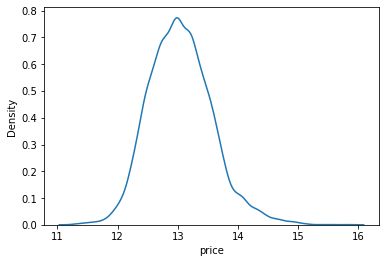

In [10]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2021        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
gboost.__class__.__name__

'GradientBoostingRegressor'

In [12]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [13]:
# 모델의 들어갈 인자값
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}
model = LGBMRegressor(random_state=random_state)

In [14]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2021), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
grid_model.cv_results_

{'mean_fit_time': array([0.23227553, 0.29759345, 0.51502409, 0.68828602]),
 'std_fit_time': array([0.05274185, 0.07196911, 0.109772  , 0.06316082]),
 'mean_score_time': array([0.01357708, 0.02954154, 0.02787075, 0.0347424 ]),
 'std_score_time': array([0.00733213, 0.01783958, 0.01083704, 0.00653283]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [27]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [28]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [33]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [34]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [35]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [36]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [37]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [38]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.0s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [39]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [40]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [41]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [42]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [43]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [45]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [46]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


In [ ]:
# def rmse_exp(y_true, y_pred):
#     return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

# def train_test_split(data, do_ohe=True):
#     df = data.drop(['id','price','data'], axis=1).copy()
#     cat_cols = df.select_dtypes('object').columns
#     for col in cat_cols:
#         if do_ohe:
#             ohe_df = pd.get_dummies(df[[col]], prefix='ohe_'+col)
#             df.drop(col, axis=1, inplace=True)
#             df = pd.concat([df, ohe_df], axis=1)
#         else:
#             le = LabelEncoder()
#             df[col] = le.fit_transform(df[col])

#     train_len = data[data['data'] == 'train'].shape[0]
#     X_train = df.iloc[:train_len]
#     X_test = df.iloc[train_len:]
#     y_train = data[data['data'] == 'train']['price']
    
#     return X_train, X_test, y_train

# def get_oof_lgb(X_train, y_train, X_test, lgb_param, verbose_eval=False, return_cv_score_only=False):

#     folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
#     oof = np.zeros(len(X_train))
#     predictions = np.zeros(len(X_test))
#     feature_importance_df = pd.DataFrame()

#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
#         if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
#         trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
#         val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

#         num_round = 100000
#         clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
#                         verbose_eval=verbose_eval, early_stopping_rounds=200)
#         oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
#         predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
#         cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        
#         if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')
        
#         fold_importance_df = pd.DataFrame()
#         fold_importance_df['feature'] = X_train.columns.tolist()
#         fold_importance_df['importance'] = clf.feature_importance('gain')
#         fold_importance_df['fold'] = fold_ + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

#     cv_score = rmse_exp(y_train, oof)
#     print(f'CV-Score: {cv_score:.6f}')
#     if return_cv_score_only: return cv_score
#     else: return oof, predictions, cv_score, feature_importance_df
    
# def plot_feature_importance(fi_df, num_feature=20):
#     cols = (fi_df[['feature', 'importance']]
#             .groupby('feature')
#             .mean()
#             .sort_values(by='importance', ascending=False)[:num_feature].index)
#     best_features = fi_df.loc[fi_df.feature.isin(cols)]

#     sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
#     plt.title('Feature Importances (averaged over folds)')
#     plt.tight_layout()
#     plt.show()
    
# def plot_numeric_for_regression(df, field, target_field='price'):
#     df = df[df[field].notnull()]

#     fig = plt.figure(figsize = (16, 7))
#     ax1 = plt.subplot(121)
    
#     sns.distplot(df[df['data'] == 'train'][field], label='Train', hist_kws={'alpha': 0.5}, ax=ax1)
#     sns.distplot(df[df['data'] == 'test'][field], label='Test', hist_kws={'alpha': 0.5}, ax=ax1)

#     plt.xlabel(field)
#     plt.ylabel('Density')
#     plt.legend()
    
#     ax2 = plt.subplot(122)
    
#     df_copy = df[df['data'] == 'train'].copy()

#     sns.scatterplot(x=field, y=target_field, data=df_copy, ax=ax2)
    
#     plt.show()
    
# def plot_categorical_for_regression(df, field, target_field='price', show_missing=True, missing_value='NA'):
#     df_copy = df.copy()
#     if show_missing: df_copy[field] = df_copy[field].fillna(missing_value)
#     df_copy = df_copy[df_copy[field].notnull()]

#     ax1_param = 121
#     ax2_param = 122
#     fig_size = (16, 7)
#     if df_copy[field].nunique() > 30:
#         ax1_param = 211
#         ax2_param = 212
#         fig_size = (16, 10)
    
#     fig = plt.figure(figsize = fig_size)
#     ax1 = plt.subplot(ax1_param)
    
#     sns.countplot(x=field, hue='data', order=np.sort(df_copy[field].unique()), data=df_copy)
#     plt.xticks(rotation=90, fontsize=11)
    
#     ax2 = plt.subplot(ax2_param)
    
#     df_copy = df_copy[df_copy['data'] == 'train']

#     sns.boxplot(x=field, y=target_field, data=df_copy, order=np.sort(df_copy[field].unique()), ax=ax2)
#     plt.xticks(rotation=90, fontsize=11)
    
#     plt.show()
    
# def load_original_data():
#     train = pd.read_csv('../input/train.csv')
#     test = pd.read_csv('../input/test.csv')

#     train_copy = train.copy()
#     train_copy['data'] = 'train'
#     test_copy = test.copy()
#     test_copy['data'] = 'test'
#     test_copy['price'] = np.nan

#     # remove outlier
#     train_copy = train_copy[~((train_copy['sqft_living'] > 12000) & (train_copy['price'] < 3000000))].reset_index(drop=True)

#     # concat train, test data to preprocess
#     data = pd.concat([train_copy, test_copy], sort=False).reset_index(drop=True)
#     data = data[train_copy.columns]

#     data.drop('date', axis=1, inplace=True)
#     data['zipcode'] = data['zipcode'].astype(str)

#     # fix skew feature
#     skew_columns = ['price']

#     for c in skew_columns:
#         data[c] = np.log1p(data[c])
        
#     return data